# Introduction

Dear viewers, welcome! <br>
We are **Ben Arviv** and **Daniel Dubinskey**, computer science students from the **Open University of Israel**, leaning towards the fields of *Data Science* and *Machine Learning*. <br>
In the *Data Science Workshop* (20936) we learned many tools and techniques for data analysis and machine learning, and for our final project we chose to focus on the field of *Computer Vision* and *Deep Learning*. As a result, we decided to perform a data science project on a dataset we found on Kaggle, which is called **Brain Tumor Detection**.

The main goal of the project is to contribute to the early detection and diagnosis of brain tumors, which aims to provide valuable support to medical professionals in creating effective treatment plans. The dataset consists of brain scans and has a diverse range of brain tumor images that are annotated to highlight the tumor regions.

## The Problem

Brain tumor detection presents multifaceted challenges stemming from the complexity and heterogeneity of brain tumors, coupled with the limitations of current diagnostic techniques. Early detection is hindered by the nonspecific nature of symptoms in the initial stages, often leading to delayed diagnosis until tumors have progressed. <br>
Imaging modalities like MRI and CT scans, while essential, require expert interpretation and may miss subtle or small tumors, especially given the intricate anatomy of the brain. Furthermore, invasive biopsy procedures for definitive diagnosis pose risks and are not always feasible or desirable. Tumor heterogeneity exacerbates the difficulty in developing universal detection methods, and the overlap of tumor tissue with normal brain structures complicates interpretation.

Access to advanced imaging and diagnostic procedures, along with the high cost, further exacerbates disparities in healthcare access. Moreover, the need for large, diverse datasets for training AI algorithms adds another layer of complexity. Addressing these challenges necessitates collaborative efforts across disciplines to innovate non-invasive detection methods, improve imaging technology, and harness AI for more accurate and accessible brain tumor diagnosis, ultimately improving patient outcomes.

In this computer vision project, we aim to develop a brain tumor detection system leveraging a dataset comprising brain scans as input images and corresponding labels denoting the coordinates of brain tumors, where present. By harnessing advanced image processing and deep learning techniques, our objective is to accurately identify and localize brain tumors within medical imaging data. The dataset serves as a critical resource for training and evaluating our model, enabling it to learn complex patterns and features indicative of tumor presence. Through precise localization of tumors within brain scans, our system can assist healthcare professionals in early diagnosis, treatment planning, and monitoring of patients with neurological conditions. By automating the detection process, we aim to enhance efficiency, reduce human error, and ultimately improve patient outcomes in the diagnosis and management of brain tumors.

# Exploratory Data Analysis (EDA)

In order to understand the dataset and the problem we are dealing with, we will perform an exploratory data analysis (EDA) to get a sense of the data and its characteristics. This process includes examining the distribution of the data, identifying patterns and trends, applying dimensionality reduction and clustering techniques, and visualizing the data to gain insights. EDA is a crucial step in the data science process, as it helps us understand the data, identify potential issues, and inform subsequent steps in the analysis and modeling process.

In [87]:
# For running purposes, we need to install the following package
# !pip install ultralytics

In [113]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
from ultralytics import YOLO

In [89]:
# Set the paths to the dataset
TRAIN_IMAGE_PATH = "train/images"
VALID_IMAGE_PATH = "valid/images"
TEST_IMAGE_PATH = "test/images"

TRAIN_LABEL_PATH = "train/labels"
VALID_LABEL_PATH = "valid/labels"
TEST_LABEL_PATH = "test/labels"

IMG_WIDTH = 139
IMG_HEIGHT = 132

Let's see what our files look like.

In [90]:
os.listdir(TRAIN_IMAGE_PATH)[:5], os.listdir(TRAIN_LABEL_PATH)[:5]

(['volume_46_slice_61_jpg.rf.391e59308aa61a1c6184a0f2d41b62f2.jpg',
  'volume_198_slice_79_jpg.rf.8c7c23a1ab721c83b4025175fcb7a034.jpg',
  'volume_323_slice_31_jpg.rf.e21e68e7259f11cb7b9c1f5ceabcf503.jpg',
  'volume_151_slice_60_jpg.rf.972f02fcc6ef2e356bdfe78ac13a35c5.jpg',
  'volume_320_slice_105_jpg.rf.ad0d93f902dba9aa847e8928ed820611.jpg'],
 ['volume_318_slice_69_jpg.rf.941f970f981354db43bccf56555bc583.txt',
  'volume_266_slice_93_jpg.rf.35488329cea5924cf8080ce006349872.txt',
  'volume_308_slice_60_jpg.rf.3ab6c84b34debdcdf892ed3348648954.txt',
  'volume_76_slice_91_jpg.rf.ebbcc4f8d29cac3a6cc80676862d87de.txt',
  'volume_99_slice_62_jpg.rf.1e748984d94cccdaa9b499eada463fe4.txt'])

It appears that the images are in `jpg` format, and the labels are in `txt` format. We will start by loading the data and examining the contents of the dataset.

In [91]:
file_paths = [os.path.join(TRAIN_LABEL_PATH, file) for file in os.listdir(TRAIN_LABEL_PATH)[:5]]

files = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        files.append(file.read())

files


['0 0.30935251798561153 0.3106060606060606 0.5179856115107914 0.4696969696969697\n1 0.3237410071942446 0.3371212121212121 0.60431654676259 0.5681818181818182',
 '0 0.38489208633093525 0.7878787878787878 0.30935251798561153 0.25757575757575757\n1 0.4316546762589928 0.7727272727272727 0.3597122302158273 0.3333333333333333',
 '1 0.3345323741007194 0.2689393939393939 0.2517985611510791 0.09848484848484848',
 '0 0.8129496402877698 0.3977272727272727 0.18705035971223022 0.1590909090909091\n1 0.7805755395683454 0.35984848484848486 0.381294964028777 0.2196969696969697\n2 0.8201438848920863 0.4053030303030303 0.17266187050359713 0.1590909090909091',
 '1 0.7194244604316546 0.7159090909090909 0.07194244604316546 0.03787878787878788']

Each label file contains zero or more rows, each row contains an index number and the coordinates of the tumor in the image. We have noticed that the labels start with an index number between 0-2, but that number isn't consistent among the labels, we will come back to this later. The coordinates are in the format $(x, y, width, height)$, where $(x, y)$ is the center of the bounding box, and $width$ and $height$ are the dimensions of the bounding box. We will use this information to visualize the bounding boxes on the images and gain insights into the distribution and characteristics of the tumors.

Next, we have to check that the data is consistent, i.e., that each image has a corresponding label file and that there are no duplicate images or labels.

In [92]:
def has_label(image_name, label_path):
    return os.path.exists(os.path.join(label_path, image_name))

def check_for_duplicates(files):
    seen = set()
    dups = set()
    
    for file in files:
        if file in seen:
            dups.add(file)
        seen.add(file)
    
    return len(dups)

def data_check(path):
    counter = 0
    dups = 0
    label_path = path.replace('images', 'labels')
    images = os.listdir(path)
    labels = os.listdir(label_path)
    
    print(f'Checking: {path}')
    
    # Checks for duplicates in the dataset
    dups = check_for_duplicates(images)
    print(f'Number of duplicate images: {dups}')
    
    dups = check_for_duplicates(labels)
    print(f'Number of duplicate labels: {dups}')
    
    # Counts images without labels
    for image_name in images:
        image_name = image_name.replace('.jpg', '.txt')
        if not has_label(image_name, label_path):
            counter += 1
    print(f"Number of images without labels: {counter}")
    
    return counter


In [93]:
def extract_labels(original_folder, new_folder, idx):
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
        
    for filename in os.listdir(original_folder):
        with open(os.path.join(original_folder, filename), 'r') as f:
            lines = f.readlines()
            
        lines_id = [line for line in lines if line.startswith(idx)]
        
        with open(os.path.join(new_folder, filename), 'w') as f:
            if lines_id:
                f.writelines(lines_id)

In [94]:
def clean_data(data_path, dir):
    os.makedirs('Clean',exist_ok=True)
    data_path = os.path.join(data_path, 'Clean')
    
    os.makedirs(os.path.join(data_path, dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(data_path, dir, 'labels'), exist_ok=True)

    labels_path = os.path.join(os.getcwd(), dir, 'labels')
    img_path = os.path.join(os.getcwd(), dir, 'images')

    new_labels_path = os.path.join(data_path, dir, 'labels')
    new_images_path = os.path.join(data_path, dir, 'images')
    
    for file_name in os.listdir(labels_path):
        file_path  = os.path.join(labels_path, file_name)
        with open(file_path, 'r') as f:
            image_file_name = file_name.replace('.txt', '.jpg')
            image_file_path = os.path.join(img_path, image_file_name)
            lines = f.readlines()
            if not lines:
                shutil.copy(file_path, new_labels_path)
                shutil.copy(image_file_path, new_images_path)
            else: 
                lines_id = [line for line in lines if line.startswith('1')]
                if lines_id:
                    with open(os.path.join(new_labels_path, file_name), 'w') as f: 
                        lines_id = lines_id[0].split(' ')
                        lines_id[0] = '0 '
                        lines_id = ' '.join(lines_id)
                        lines_id = lines_id.strip()
                        f.writelines(lines_id)
                        shutil.copy(image_file_path, new_images_path)
            
    

In [95]:
paths = [TRAIN_IMAGE_PATH, VALID_IMAGE_PATH, TEST_IMAGE_PATH]
for path in paths:
    data_check(path)
    print()

Checking: train/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0

Checking: valid/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0

Checking: test/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0



We see that each image has a corresponding label file, which means that we have a one-to-one mapping between images and labels. This will allow us to associate the tumor annotations with the corresponding images and use them for training and evaluation of our model. We also verified that there are no duplicate images or labels in the dataset, ensuring that the data is clean and consistent.

Using the `cv2` library, we can read the images properly.

In [96]:
def read_images(imgs_path):
    images = []
    
    for img_name in os.listdir(imgs_path):
        img = cv2.imread(os.path.join(imgs_path, img_name))
        images.append(img)
        
    return images

In [97]:
# Load train images
train_images = read_images(TRAIN_IMAGE_PATH)

In [98]:
train_images[0].shape, train_images[0]

((132, 139, 3),
 array([[[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        ...,
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]],
 
        [[12, 12, 12],
         [12, 12, 12],
         [12, 12, 12],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [12, 12, 12]]], dtype=uint8))

Each image is a 3D array, where the first two dimensions represent the pixel values of the image, and the third dimension represents the color channels (RGB). 

In [99]:
def read_labels_by_index(lbls_path, imgs_path, images):
    labels = {'0': [], '1': [], '2': []}
    
    for i, file_path in enumerate(os.listdir(imgs_path)):
        file_path = file_path.replace('.jpg', '.txt')
        file_path = os.path.join(lbls_path, file_path)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            if len(lines) == 0:
                continue
            
            for line in lines:
                line = line.strip().split()
                
                idx, x, y, width, height = list(map(float, line))
                size = (width * IMG_WIDTH) * (height * IMG_HEIGHT)
                
                labels[str(int(idx))].append(size)
        
    return labels

In [100]:
def read_labels(lbls_path, imgs_path, images):
    labels = pd.DataFrame(columns=['number of tumors', 'list of tumors', 'sizes of tumors'])
    unincluded = 0
    flag = False

    for i, file_path in enumerate(os.listdir(imgs_path)):
        file_path = file_path.replace('.jpg', '.txt')
        file_path = os.path.join(lbls_path, file_path)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            boxes_list = []
            sizes_list = []
            if len(lines) == 0:
                labels.loc[i] = [0, [], []]
                continue
            
            for line in lines:
                line = line.strip().split()
                
                idx, x, y, width, height = list(map(float, line))"
                xmin = (x - width / 2) * IMG_WIDTH 
                ymin = (y - height / 2) * IMG_HEIGHT
                xmax = (x + width / 2) * IMG_WIDTH
                ymax = (y + height / 2) * IMG_HEIGHT 
                
                size = (width / IMG_WIDTH) * (height / IMG_HEIGHT)
                sizes_list.append([size])
                boxes_list.append([xmin, ymin, xmax, ymax])
            
                
            labels.loc[i] = [len(boxes_list), boxes_list, sizes_list]
            
    labels['average tumor size'] = labels['sizes of tumors'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
    
    return labels

In [119]:
def read_cleaned_labels(lbls_path, imgs_path, images):
    labels = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'size'])
    
    for i, file_path in enumerate(os.listdir(imgs_path)):
        file_path = file_path.replace('.jpg', '.txt')
        file_path = os.path.join(lbls_path, file_path)
        
        if not os.path.exists(file_path):
            with open(file_path, 'w') as file:
                pass
        
        with open(file_path, 'r') as file:
            line = file.readlines()
            if len(line) == 0: # if there are no tumors in the image
                labels.loc[i] = [0, 0, 0, 0, 0]
                continue
            line = line[0].split()
            idx, x, y, width, height = list(map(float, line))
            
            xmin = (x - width / 2) * IMG_WIDTH
            ymin = (y - height / 2) * IMG_HEIGHT
            xmax = (x + width / 2) * IMG_WIDTH
            ymax = (y + height / 2) * IMG_HEIGHT
            size = (width / IMG_WIDTH) * (height / IMG_HEIGHT)
            
            labels.loc[i] = [xmin, ymin, xmax, ymax, size]
            
    return labels

In [102]:
def count_labels(path):
    dict = {0:0, 1:0, 2:0}
    for i, file in enumerate(os.listdir(path)):
        file = os.path.join(path, file)
        with open(file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip().split()
                idx, x, y, w, h = list(map(float,line))
                dict[idx] += 1
    keys = list(dict.keys())
    values = list(dict.values())
    
    plt.bar(keys, values, color=['red', 'green', 'blue'])
    plt.xticks(keys)
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    plt.title('Frequency of Tumors by Index')
    plt.show()

In [103]:
def count_0_2_indices(path):
    cnt = 0
    paths = []
    for i, file_path in enumerate(os.listdir(path)):
        file_path = os.path.join(path, file_path)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            if len(lines) == 1: 
                for line in lines: 
                    line = line.strip().split() 
                    idx, x, y, width, height = list(map(float, line))
                    if (idx!=1):
                        cnt +=1
                        paths.append(file_path)
    return cnt, paths

In [104]:
def get_dimensions(df):
    width = df['xmax'] - df['xmin']
    height = df['ymax'] - df['ymin']
    aspect_ratios = width / height

    return aspect_ratios

Now it's time to load the labels. We will create a *DataFrame* object to store the labels, with each row representing an image and its corresponding tumor coordinates, sizes and average size (if present). This will allow us to easily access and manipulate the labels, and merge them with the image data for visualization and analysis.

In [105]:
# Load train labels
train_labels = read_labels(TRAIN_LABEL_PATH, TRAIN_IMAGE_PATH, train_images)
train_labels.head()

,number of tumors,list of tumors,sizes of tumors,average tumor size
0,1,"[[23.000000000000004, 68.0, 95.99999999999999,...",[[9.107405793065767e-06]],9.107406e-06
1,3,"[[52.0, 18.999999999999996, 78.0, 39.0], [37.0...","[[1.5446350333966729e-06], [1.0040127717078374...",5.002241e-06
2,1,"[[48.0, 25.0, 53.99999999999999, 32.0]]",[[1.2475898346665436e-07]],1.247590e-07
3,3,"[[0.9999999999999996, 66.0, 23.999999999999996...","[[1.2980875184506655e-06], [6.546876180012053e...",3.333837e-06
4,2,"[[5.999999999999999, 18.0, 40.0, 49.0], [21.0,...","[[3.1308563946155642e-06], [5.792381375237524e...",1.855047e-06


In [106]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6930 entries, 0 to 6929
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number of tumors    6930 non-null   int64  
 1   list of tumors      6930 non-null   object 
 2   sizes of tumors     6930 non-null   object 
 3   average tumor size  6930 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 270.7+ KB


In [107]:
train_labels.describe()

,number of tumors,average tumor size
count,6930.000000,6930.000000
mean,2.170418,0.000005
std,0.916938,0.000004
min,0.000000,0.000000
25%,1.000000,0.000002
50%,3.000000,0.000004
75%,3.000000,0.000007
max,3.000000,0.000030


It is also a good time to figure out what the index number in the labels represents.

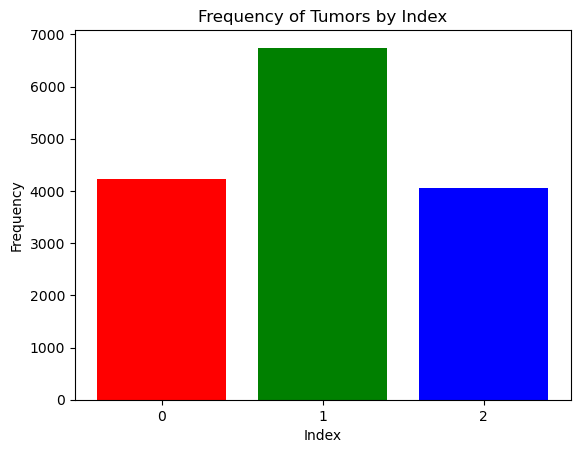

In [108]:
count_labels(TRAIN_LABEL_PATH)

It looks like index 1 is the most common index in the labels, and appears in almost 7000 images - basically, all of the training images. Indices 0 and 2 are less common, and appear in about $\frac{2}{3}$ of the images. Are there any images that contain the index 0 or 2 but not 1?

In [109]:
count, no_1_paths = count_0_2_indices(TRAIN_LABEL_PATH) # added paths to labels without index 1 - for later discussion
print('Number of 0 and 2 indices: ', count)

Number of 0 and 2 indices:  55


Not too much - only 55 images. Since our dataset is relatively large, we can afford to remove these images from the dataset.

Now, what about the sizes of the tumors? Is there any correlation between the size of the tumor and the index?

In [110]:
labels_dict = read_labels_by_index(TRAIN_LABEL_PATH, TRAIN_IMAGE_PATH, train_images)
avgs = []

for key in labels_dict.keys():
    avgs.append(np.mean(labels_dict[key]))
    
for i in range(len(avgs)):
    print(f'Average size of index {i}: {avgs[i]}')

Average size of index 0: 1182.2640396413403
Average size of index 1: 2664.2779836916234
Average size of index 2: 1190.2999014292755


Thing are starting to get interesting. The average size of the tumors in the images with index 1 is significantly larger than those with index 0 or 2. However, the average size of the tumors with indices 0 and 2 is pretty similar. We should dig a little deeper here, we might onto something.

Let's try the next plot, of bounding boxes taken from images that contain all three indices.

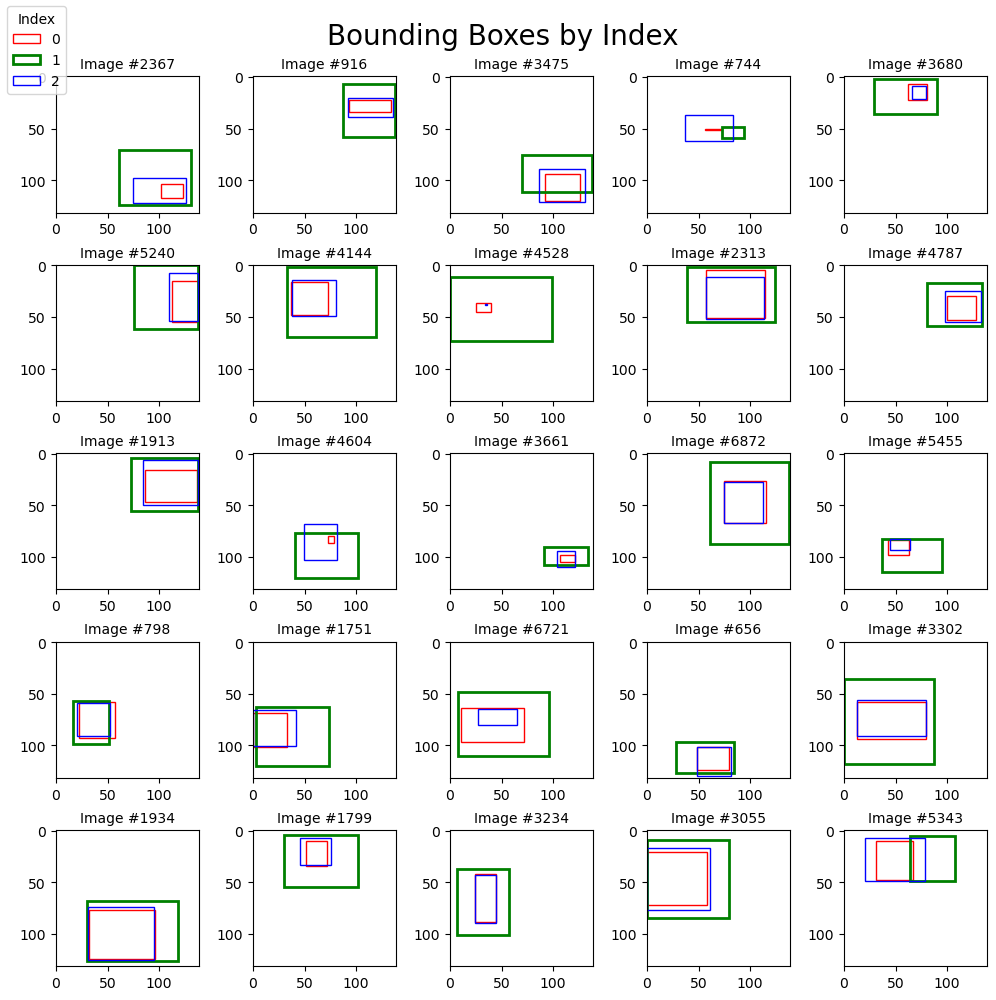

In [111]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Bounding Boxes by Index', fontsize=20)

image = np.ones((132, 139, 3), dtype=np.uint8) * 255
temp = random.randint(0, len(train_images))
colors = ['r', 'g', 'b']
width = [1, 2, 1]
printed = []
for i, ax in enumerate(axes.flat):
    flag = True
    while flag:
        if temp not in printed and train_labels['number of tumors'].loc[temp] == 3:
            flag = False
            for j, box in enumerate(train_labels['list of tumors'].loc[temp]):
                xmin, ymin, xmax, ymax = box
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=colors[j], linewidth=width[j])
                ax.add_patch(rect)
                ax.set_title(f'Image #{temp}', fontsize=10)
                ax.imshow(image)
        printed.append(temp)
        temp = random.randint(0, len(train_images))
          
plt.figlegend(['0', '1', '2'], loc='upper left', title='Index')
plt.tight_layout()
plt.show()

Bingo! Kind of. In most of the images, the bounding boxes with index 1 contain the bounding boxes with indices 0 and 2. This means that the bounding boxes with index 1 are the least precise, and all of the boxes in fact represent the same tumor. This is a very important insight, as it means that we can treat all of the bounding boxes as the same tumor, and we can use the bounding boxes with index 1 to train our model. 

In that case, it is good to perform some data cleaning and remove the bounding boxes with indices 0 and 2 from the labels. The following code will do that.

In [114]:
my_path = os.getcwd()
clean_data(my_path, 'train')
clean_data(my_path, 'valid')
clean_data(my_path, 'test')

In [116]:
new_path = os.path.join(os.getcwd(), 'Clean')
TRAIN_LABEL_PATH = os.path.join(new_path, 'train', 'labels')
VALID_LABEL_PATH = os.path.join(new_path, 'valid', 'labels')
TEST_LABEL_PATH = os.path.join(new_path, 'test', 'labels')

We have to reload the labels, so that we can continue with the analysis based only on the bounding boxes with index 1.

In [120]:
train_labels = read_cleaned_labels(TRAIN_LABEL_PATH, TRAIN_IMAGE_PATH, train_images)
train_labels.head()

,xmin,ymin,xmax,ymax,size
0,23.0,68.0,96.0,110.0,9.107406e-06
1,37.0,3.0,102.0,55.0,1.004013e-05
2,48.0,25.0,54.0,32.0,1.247590e-07
3,9.0,59.0,67.0,97.0,6.546876e-06
4,6.0,18.0,40.0,49.0,3.130856e-06


In [121]:
train_labels.describe()

,xmin,ymin,xmax,ymax,size
count,6930.000000,6930.000000,6930.000000,6930.000000,6930.000000
mean,43.507215,44.902453,97.620491,84.616306,0.000008
std,29.179767,32.428947,31.231430,33.415473,0.000006
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,14.000000,77.000000,58.000000,0.000003
50%,40.000000,41.000000,103.000000,87.000000,0.000007
75%,66.000000,74.000000,123.000000,116.000000,0.000011
max,137.000000,127.000000,139.000000,132.000000,0.000043


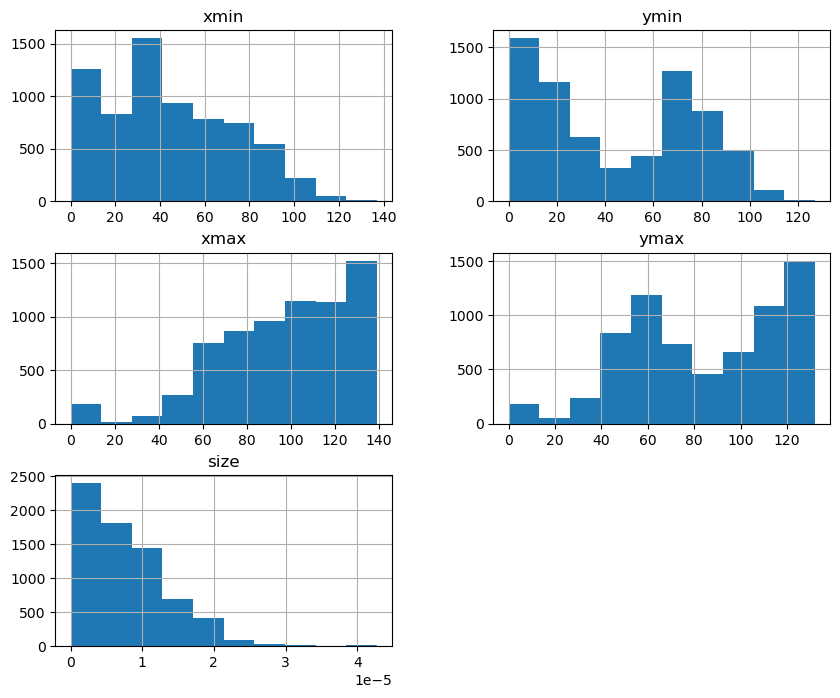

In [123]:
train_labels.hist(figsize=(10, 8))
plt.show()

The bounding boxes' coordinates doesn't tell us much about the tumors, but the size histogram is actually interesting. We can see that most of the tumors are of a similar size, but there are some with larger sizes. The histogram is right-skewed, indicating that the majority of tumors are small to medium in size, with a few larger tumors. 

We already saw that the bounding boxes have different sizes. Let's have a look at the distribution of the aspect ratios of the bounding boxes.

/Users/benarviv/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Bounding Box Aspect Ratio Distribution')

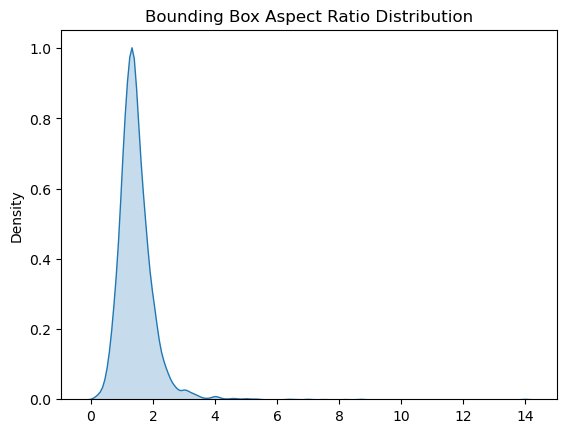

In [124]:
aspect_ratios = get_dimensions(train_labels)
sns.kdeplot(aspect_ratios, fill=True)
plt.title('Bounding Box Aspect Ratio Distribution')

The aspect ratios are relatively identical, with most of the tumors having an aspect ratio that lies between 1 and 2. This indicates that the tumors are generally elongated or oval-shaped, rather than circular or irregluar.

What about the locations of the bounding boxes? Are they centered around a specific region of the brain?

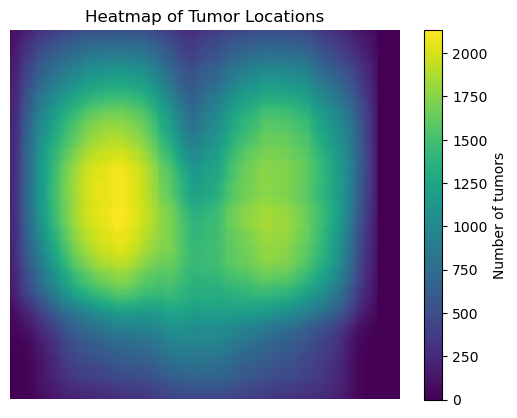

In [125]:
heatmap = np.zeros((IMG_HEIGHT, IMG_WIDTH))

for i in range(len(train_labels)):
    xmin, ymin, xmax, ymax = train_labels.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]
    heatmap[int(xmin):int(xmax), int(ymin):int(ymax)] += 1
    
plt.imshow(heatmap, origin='lower')
plt.axis('off')
plt.colorbar(label='Number of tumors')
plt.title('Heatmap of Tumor Locations')
plt.show()

That heatmap reveals that the tumors are predominantly located in the central region of the brain scans, but for some reason, they are split into two 'kind-of' clusters - in the middle left and in the middle right of the brain scans, with a few outliers in the bottom, between the two clusters. This distribution may be due to the nature of the brain anatomy and the prevalence of tumors in specific regions of the brain.

All that being said, but what about the images themselves? Are they all of the same size? Are they all in the same color space? It is a good time to have a look at them.

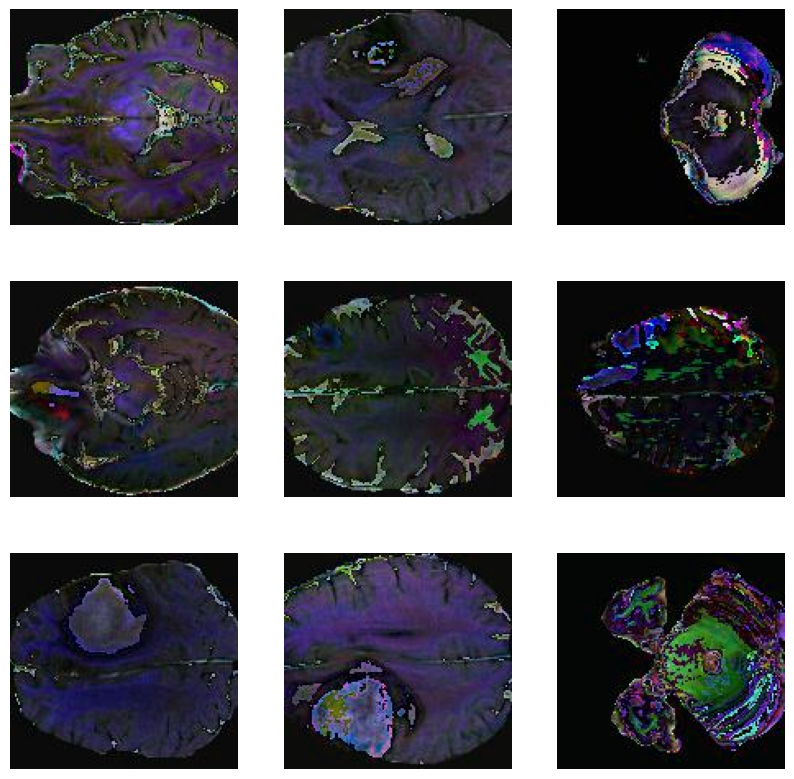

In [126]:
# Plot images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_images[i])
    ax.axis('off')

All of the images are brain scans, in what appears to be different axial depths of the brain, according to the actual brain scan and color of the image. All of the images are of the same size, and they may or may not contain tumors. 

The resulting images should be displayed with the bounding boxes around the tumors, if present, as in the example below:

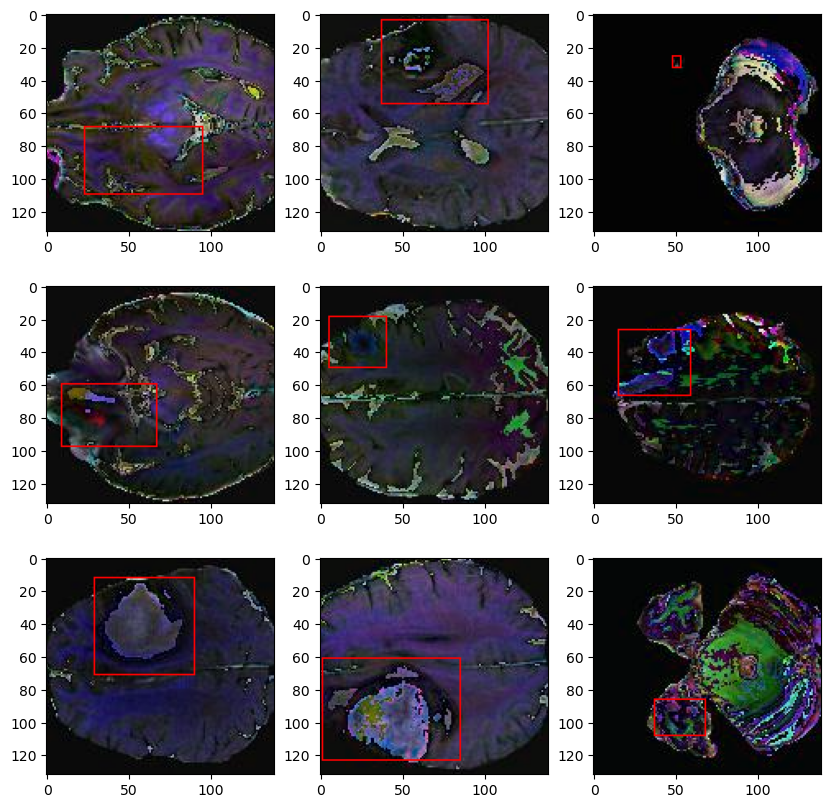

In [127]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    img = train_images[i]
    xmin, ymin, xmax, ymax, _ = list(map(int, train_labels.loc[i]))
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
    ax.imshow(img)

Now for some statistics about the images:

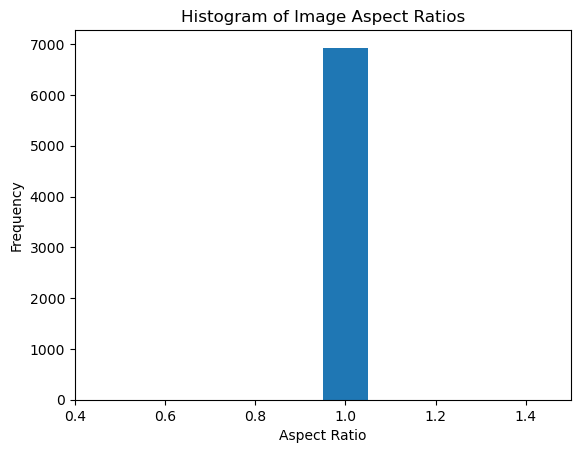

In [128]:
# Calculate the aspect ratio of each image
aspect_ratios = [img_width / img_height for img_width, img_height in [img.shape[:2] for img in train_images]]

# Plot the histogram
plt.hist(aspect_ratios, bins=10)
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Image Aspect Ratios')
plt.show()


All of the images are of the same aspect ratio and dimensions, which is a good thing, as it will allow us to train a model on the images without having to worry about resizing them. Since the images' dimensions are $132\times 139\times 3$, we will have $51,708$ features for each image (quite a lot).

Let's take a closer look at the color distribution of the images. We will plot the histograms of the pixel values for each color channel (R, G, B) to visualize the distribution of colors in the images.

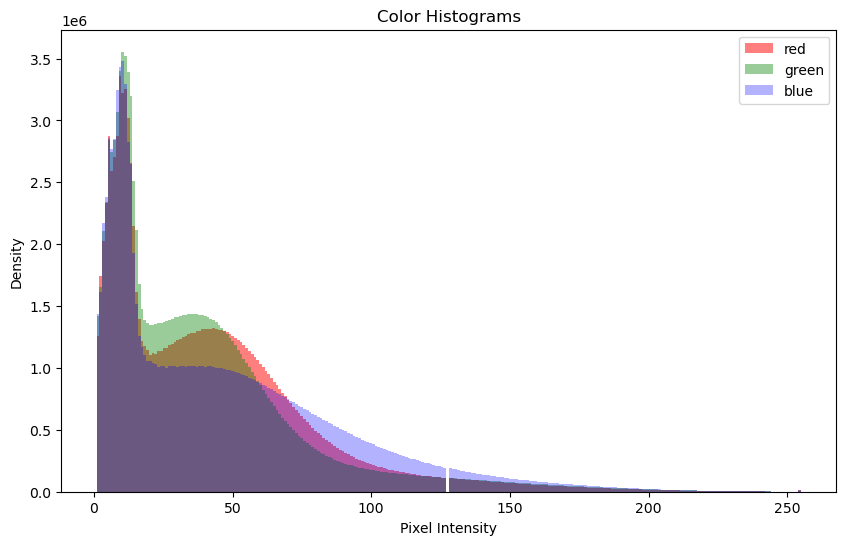

In [129]:
# Flatten the images and separate color channels
red = np.array([image[:, :, 0].flatten() for image in train_images]).flatten()
green = np.array([image[:, :, 1].flatten() for image in train_images]).flatten()
blue = np.array([image[:, :, 2].flatten() for image in train_images]).flatten()

red = red[red != 0]
green = green[green != 0]
blue = blue[blue != 0]

plt.figure(figsize=(10, 6))
plt.hist(red, label='red', bins=256, density=False, color='red', alpha=0.5)
plt.hist(green, label='green', bins=256, density=False, color='green', alpha=0.4)
plt.hist(blue, label='blue', bins=256, density=False, color='blue', alpha=0.3)

plt.title('Color Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()

It seems that the images are mostly dark, with two peaks in the histograms, one around 0 and the other around 50. This indicates that the images have a low dynamic range, with most pixel values concentrated around the lower end of the scale. This could be due to the nature of the brain scans and the imaging modality used to capture them. The histograms show that the images have a relatively uniform distribution of pixel values across the color channels, with no significant outliers or anomalies.

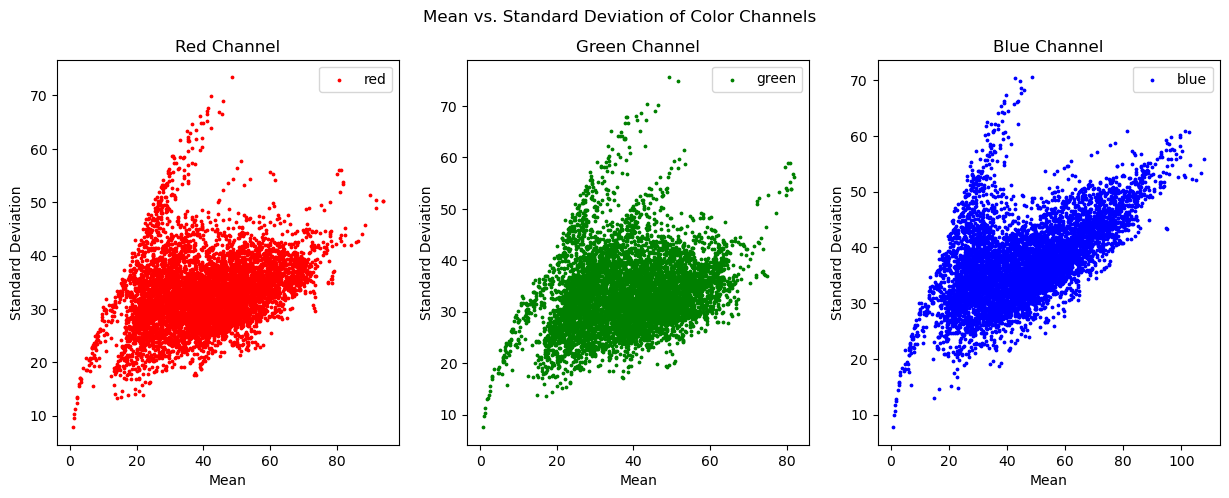

In [130]:
color_df = pd.DataFrame(columns=['red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std'])
channels = ['red', 'green', 'blue']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for channel in channels:
    color_df[f'{channel}_mean'] = [np.mean(img[:, :, channels.index(channel)]) for img in train_images]
    color_df[f'{channel}_std'] = [np.std(img[:, :, channels.index(channel)]) for img in train_images]
    ax = axes[channels.index(channel)]
    ax.scatter(color_df[f'{channel}_mean'], color_df[f'{channel}_std'], label=channel, c='r' if channel == 'red' else 'g' if channel == 'green' else 'b', s=3)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Standard Deviation')
    ax.set_title(f'{channel.capitalize()} Channel')
    ax.legend()
    
fig.suptitle('Mean vs. Standard Deviation of Color Channels')
plt.show()


This plot supports our previous observation that the images are mostly dark, with pixel values concentrated around the lower end of the scale, and the variability in pixel values across the color channels is relatively low. In addition, we see that the pixel values are forming one big cluster, which indicates that the images are not very diverse in terms of color distribution. This means that the color information may not be as informative for distinguishing between tumor and non-tumor regions in the images, and other features such as texture and shape may play a more significant role in tumor detection.

# Model Training

Now that we have analyzed the data and gained insights into the characteristics of the tumors, we can proceed with training a model to detect brain tumors in the images. We will use various approaches to develop a robust and accurate tumor detection system, and our goal is to achieve high performance in terms of *accuracy*, *precision*, *recall*, and *F1 score*. We will experiment with different deep learning architectures, loss functions, optimizers, and hyperparameters to optimize the model's performance and achieve the best results.

In order to detect brain tumors in the images, we will use deep learning techniques that are based on some of the most popular and effective architectures in the field of computer vision, such as *R-CNN*, *YOLO*, and *SSD*, as well as custom architectures that we will design and implement. 

In our evaluation, we will focus on the following metrics:

- **Recall**: $\frac{TP}{P}$<br>
The recall metric measures the proportion of true positive predictions among all actual positive cases in the dataset. It indicates the model's ability to correctly identify positive cases and avoid false negatives.

- **Precision**: $\frac{TP}{TP+FP}$<br>
The precision metric measures the proportion of true positive predictions among all positive predictions made by the model. It indicates the accuracy of the model in identifying positive cases and avoiding false positives.

- **F1 score**: $\frac{2\cdot Precision \cdot Recall}{Precision + Recall}$<br>
The F1 score is a metric used to assess the accuracy of a classification model. It takes into account both precision and recall (sensitivity).

- **Confidence**: <br>
The confidence metric quantifies the model's certainty in its predictions. It is represented as a numerical value between 0 and 1, where higher values indicate greater confidence in the model's predictions.

- **F1-Confidence curve** <br>
The F1-Confidence curve is a graphical representation of the relationship between the F1 score and the confidence threshold used to make predictions. It provides insights into the trade-off between precision and recall at different confidence levels, allowing us to optimize the model's performance based on the desired balance between precision and recall.


In [131]:
EPOCHS = 5
BATCH = 128
IMG_SIZE = 140

In [132]:
def plot_image(path):
    img = mpimg.imread(path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## YOLOv8n Model

The **You Only Look Once (YOLO)** algorithm is a popular object detection algorithm that is known for its speed and accuracy. YOLO divides the image into a grid and predicts bounding boxes and class probabilities for each grid cell.

The YOLOv8n model is the smallest version of the YOLOv8 architecture, and is optimized for speed and efficiency. We will begin by training this model on our train and validation datasets, because it is the fastest and simplest model to train.

In [76]:
%%writefile tumor_v8n.yaml
path: '/Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection' 
train: 'train/images'
val: 'valid/images'

#class names
names:
    0: 'Tumor'

Writing tumor_v8n.yaml


In [ ]:
model = YOLO('yolov8m.pt')

In [66]:
model = YOLO('yolov8n.pt')

In [67]:
results = model.train(
    data = 'tumor_v8n.yaml',
    imgsz = IMG_SIZE,
    epochs = EPOCHS,
    batch = BATCH,
    name = 'output'
)

Ultralytics YOLOv8.2.2 🚀 Python-3.11.0 torch-2.2.0 CPU (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=tumor_v8.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=240, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=output11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, 

Fontconfig warning: ignoring UTF-8: not a valid region tag


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/train/labels.cache... 6930 images, 79 backgrounds, 0 corrupt: 100%|██████████| 6930/6930 [00:00<?, ?it/s]
val: Scanning /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/valid/labels.cache... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]


Plotting labels to runs/detect/output11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/detect/output11
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.889      2.383      1.643          6        256: 100%|██████████| 867/867 [03:30<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:30<00:00,  1.36it/s]


                   all       1980       4380      0.399      0.412      0.373      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.794        1.9      1.581          5        256: 100%|██████████| 867/867 [03:28<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:31<00:00,  1.36it/s]


                   all       1980       4380      0.475      0.453      0.416      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.731      1.761      1.546          7        256: 100%|██████████| 867/867 [03:27<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:36<00:00,  1.29it/s]


                   all       1980       4380      0.566      0.481      0.497      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.671      1.633      1.505          4        256: 100%|██████████| 867/867 [03:29<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:29<00:00,  1.39it/s]


                   all       1980       4380      0.644      0.487      0.528      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.605      1.528       1.47          4        256: 100%|██████████| 867/867 [03:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:30<00:00,  1.37it/s]


                   all       1980       4380      0.663      0.532      0.568      0.292

5 epochs completed in 0.419 hours.
Optimizer stripped from runs/detect/output11/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/output11/weights/best.pt, 6.2MB

Validating runs/detect/output11/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.11.0 torch-2.2.0 CPU (Apple M2 Pro)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [01:24<00:00,  1.46it/s]


                   all       1980       4380      0.662      0.532      0.568      0.292
                     0       1980       1246      0.627       0.36      0.426      0.179
                     1       1980       1944      0.729      0.716      0.748      0.448
                     2       1980       1190       0.63       0.52      0.531      0.249
Speed: 0.1ms preprocess, 41.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/output11


This is a relatively fast model, and it took us about 30 minutes to train it on the dataset. Now we are able to discuss its performance.

In [82]:
output_dir = 'runs/detect/output'
f1_curve = os.path.join(output_dir, 'F1_curve.png')
p_curve = os.path.join(output_dir, 'P_curve.png')
pr_curve = os.path.join(output_dir, 'PR_curve.png')
r_curve = os.path.join(output_dir, 'R_curve.png')
confusion_matrix = os.path.join(output_dir, 'confusion_matrix.png')
labels_corr = os.path.join(output_dir, 'labels_correlogram.png')
labels_res = os.path.join(output_dir, 'labels.png')
results = os.path.join(output_dir, 'results.csv')

The first plot will be the *Confusion Matrix*.

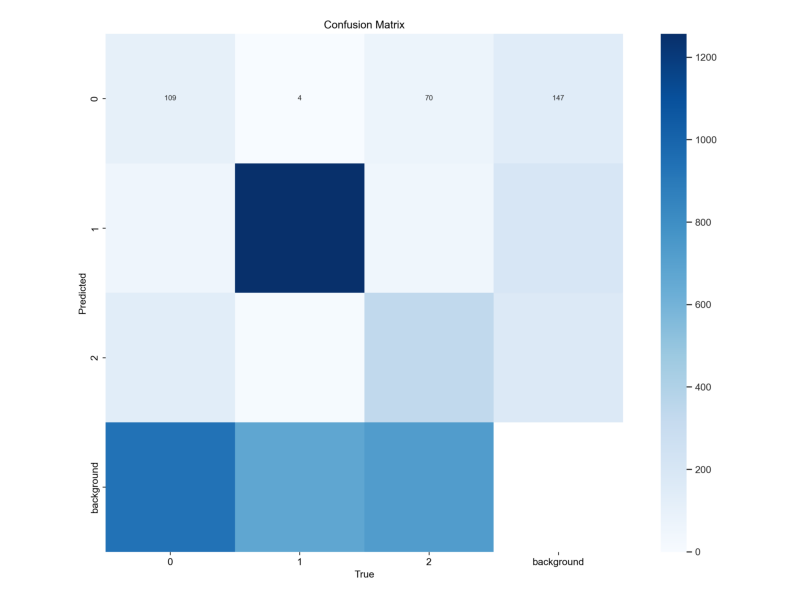

In [85]:
plot_image(confusion_matrix)

To be honest, it looks quite bad. We want the diagonal to be as dark as possible, and the other cells to be as light as possible. This means that the model is making a lot 

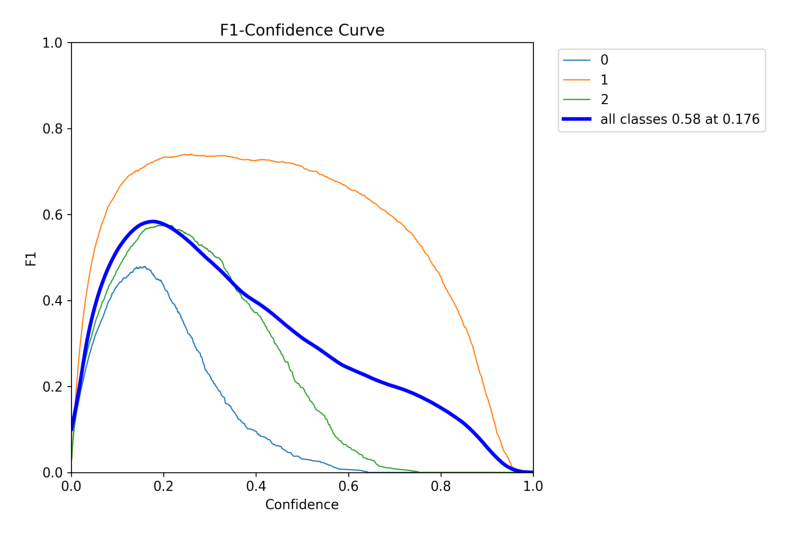

In [84]:
plot_image(f1_curve)

## YOLOv8s Model

In [80]:
%%writefile tumor_v8s.yaml
path: '/Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection'
train: 'train/images'
val: 'valid/images'
test: 'test/images'

#class names
names:
    0: '0'
    1: '1'
    2: '2'

Overwriting tumor_v8s.yaml


In [78]:
model = YOLO('yolov8s.pt')

In [81]:
results = model.train(
    data = 'tumor_v8s.yaml',
    imgsz = IMG_SIZE,
    epochs = EPOCHS,
    batch = BATCH,
    name = 'output'
)

Ultralytics YOLOv8.2.2 🚀 Python-3.11.0 torch-2.2.0 CPU (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=tumor_v8s.yaml, epochs=5, time=None, patience=100, batch=128, imgsz=140, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=output3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

train: Scanning /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/train/labels.cache... 6930 images, 79 backgrounds, 0 corrupt: 100%|██████████| 6930/6930 [00:00<?, ?it/s]
val: Scanning /Users/benarviv/Documents/OpenU/2024א/Data Science Workshop/Data Science Project/Brain-Tumor-Detection/valid/labels.cache... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]

Plotting labels to runs/detect/output3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 160 train, 160 val
Using 0 dataloader workers
Logging results to runs/detect/output3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.888      2.236      1.525         51        160: 100%|██████████| 55/55 [06:32<00:00,  7.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:55<00:00,  6.93s/it]

                   all       1980       4380      0.315      0.457      0.359      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.675      1.498      1.356         75        160: 100%|██████████| 55/55 [06:31<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:54<00:00,  6.84s/it]

                   all       1980       4380      0.301      0.413      0.318      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.659      1.437      1.336         60        160: 100%|██████████| 55/55 [06:49<00:00,  7.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:58<00:00,  7.36s/it]

                   all       1980       4380      0.511      0.501      0.501      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.606      1.346      1.301         72        160: 100%|██████████| 55/55 [06:55<00:00,  7.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:59<00:00,  7.40s/it]

                   all       1980       4380      0.658      0.513      0.552      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.528      1.254      1.265         55        160: 100%|██████████| 55/55 [06:51<00:00,  7.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:57<00:00,  7.16s/it]

                   all       1980       4380      0.717      0.552      0.609      0.312



5 epochs completed in 0.642 hours.
Optimizer stripped from runs/detect/output3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/output3/weights/best.pt, 22.5MB

Validating runs/detect/output3/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.11.0 torch-2.2.0 CPU (Apple M2 Pro)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:53<00:00,  6.73s/it]


                   all       1980       4380      0.718      0.552      0.609      0.312
                     0       1980       1246      0.734      0.394      0.492       0.21
                     1       1980       1944      0.755      0.718      0.756      0.437
                     2       1980       1190      0.664      0.546      0.578      0.289
Speed: 0.0ms preprocess, 26.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/output3
